# Detecting face that generated by AI with EfficientNet

Vidya Haikal Imad Fadly

1301204253

In [2]:
import pandas as pd
import numpy as np
import cv2
import PIL
import matplotlib.pyplot as plt
import os
import random
import tensorflow as tf
import seaborn as sn
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay,classification_report
from tensorflow import keras
from tensorflow.keras.preprocessing.image import load_img
from keras.layers import Dense, Activation,Dropout,Conv2D, MaxPooling2D,BatchNormalization
from keras import regularizers
from keras.models import Model, load_model
from keras.optimizers import Adam, Adamax
from keras import backend as K
from google.colab import drive

## Download and Load Image

In [3]:
from google.colab import files

files.upload() #this will prompt you to upload the kaggle.json

Saving kaggle.json to kaggle (1).json


{'kaggle.json': b'{"username":"haikalvidya","key":"e8ece883d0a75c4649f85a83a5377e63"}'}

In [4]:
!pip install -q kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 /root/.kaggle/kaggle.json

In [5]:
!kaggle datasets download -d xhlulu/140k-real-and-fake-faces

140k-real-and-fake-faces.zip: Skipping, found more recently modified local copy (use --force to force download)


In [6]:
!unzip 140k-real-and-fake-faces.zip

Streaming output truncated to the last 5000 lines.
  inflating: real_vs_fake/real-vs-fake/valid/real/34828.jpg  
  inflating: real_vs_fake/real-vs-fake/valid/real/34832.jpg  
  inflating: real_vs_fake/real-vs-fake/valid/real/34836.jpg  
  inflating: real_vs_fake/real-vs-fake/valid/real/34839.jpg  
  inflating: real_vs_fake/real-vs-fake/valid/real/34847.jpg  
  inflating: real_vs_fake/real-vs-fake/valid/real/34848.jpg  
  inflating: real_vs_fake/real-vs-fake/valid/real/34852.jpg  
  inflating: real_vs_fake/real-vs-fake/valid/real/34861.jpg  
  inflating: real_vs_fake/real-vs-fake/valid/real/34864.jpg  
  inflating: real_vs_fake/real-vs-fake/valid/real/34868.jpg  
  inflating: real_vs_fake/real-vs-fake/valid/real/34877.jpg  
  inflating: real_vs_fake/real-vs-fake/valid/real/34883.jpg  
  inflating: real_vs_fake/real-vs-fake/valid/real/34887.jpg  
  inflating: real_vs_fake/real-vs-fake/valid/real/34891.jpg  
  inflating: real_vs_fake/real-vs-fake/valid/real/34894.jpg  
  inflating: real_v

In [6]:
base_path="real_vs_fake/real-vs-fake/"

In [7]:
!ls -1 -t real_vs_fake/real-vs-fake/train/real| head -2

69768.jpg
69769.jpg


(-0.5, 255.5, 255.5, -0.5)

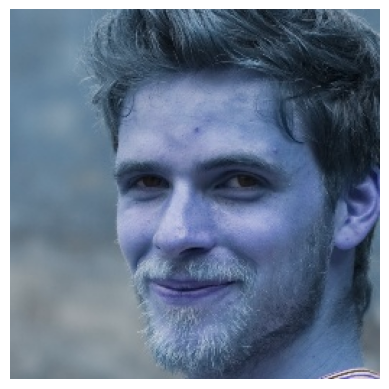

In [8]:
image = cv2.imread(base_path + 'train/real/69768.jpg')
plt.imshow(image)
plt.axis('off')

In [9]:
!kaggle datasets download -d hamzaboulahia/hardfakevsrealfaces

 98% 15.0M/15.3M [00:01<00:00, 13.9MB/s]
100% 15.3M/15.3M [00:01<00:00, 8.52MB/s]


In [10]:
!unzip hardfakevsrealfaces.zip

Archive:  hardfakevsrealfaces.zip
  inflating: data.csv                
  inflating: fake/fake_1.jpg         
  inflating: fake/fake_10.jpg        
  inflating: fake/fake_100.jpg       
  inflating: fake/fake_101.jpg       
  inflating: fake/fake_102.jpg       
  inflating: fake/fake_103.jpg       
  inflating: fake/fake_104.jpg       
  inflating: fake/fake_105.jpg       
  inflating: fake/fake_106.jpg       
  inflating: fake/fake_107.jpg       
  inflating: fake/fake_108.jpg       
  inflating: fake/fake_109.jpg       
  inflating: fake/fake_11.jpg        
  inflating: fake/fake_110.jpg       
  inflating: fake/fake_111.jpg       
  inflating: fake/fake_112.jpg       
  inflating: fake/fake_113.jpg       
  inflating: fake/fake_114.jpg       
  inflating: fake/fake_115.jpg       
  inflating: fake/fake_116.jpg       
  inflating: fake/fake_117.jpg       
  inflating: fake/fake_118.jpg       
  inflating: fake/fake_119.jpg       
  inflating: fake/fake_12.jpg        
  inflating: fak

(-0.5, 299.5, 299.5, -0.5)

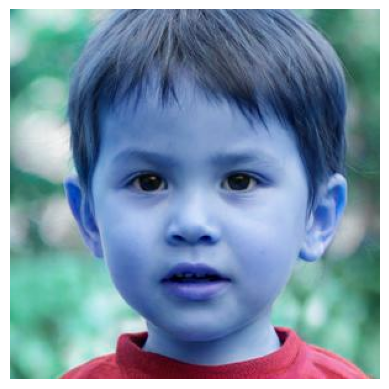

In [11]:
image = cv2.imread('fake/fake_338.jpg')
plt.imshow(image)
plt.axis('off')

## Preprocessing data

In [12]:
if not os.path.isdir("train"):
  os.mkdir("train")
  os.mkdir("train/fake")
  os.mkdir("train/real")
if not os.path.isdir("valid"):
  os.mkdir("valid")
  os.mkdir("valid/fake")
  os.mkdir("valid/real")
if not os.path.isdir("test"):
  os.mkdir("test")
  os.mkdir("test/fake")
  os.mkdir("test/real")

In [13]:
def plot_img(path, set_):
    dir_ = path
    k = 0
    random_numbers = random.sample(range(0, len(os.listdir(os.path.join(dir_)))), 9)
    fig, ax = plt.subplots(3,3, figsize=(10,10))
    for j in range(3):
        for i in range(3):
            filename = os.path.join(dir_, os.listdir(os.path.join(dir_))[random_numbers[k]])
            print(filename[-14:])
            img = load_img(filename)
            ax[j,i].imshow(img)
            ax[j,i].set_title(filename[-14:])
            ax[j,i].axis('off')
            k +=1
    plt.suptitle(set_ + ' faces')
    return plt

### First Dataset

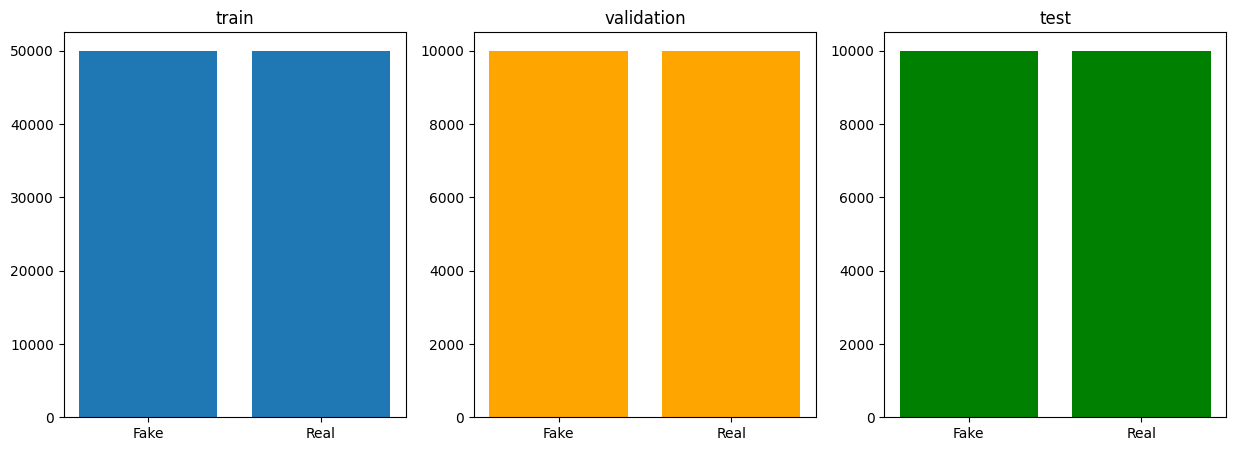

In [14]:
df_train = pd.read_csv('train.csv',index_col=0)
df_val = pd.read_csv('valid.csv',index_col=0)
df_test = pd.read_csv('test.csv',index_col=0)
y_train = df_train['label']
X_train = df_train['path']
y_val = df_val['label']
X_val = df_val['path']
y_test = df_test['label']
X_test = df_test['path']
fig, axs = plt.subplots(1,3,figsize=(15,5))
axs[0].bar(y_train.value_counts().index, y_train.value_counts(), tick_label=['Real','Fake'])
axs[1].bar(y_val.value_counts().index, y_val.value_counts(), tick_label=['Real','Fake'], color='orange')
axs[2].bar(y_test.value_counts().index, y_test.value_counts(), tick_label=['Real','Fake'], color='green')
axs[0].title.set_text("train")
axs[1].title.set_text("validation")
axs[2].title.set_text("test")

real/07235.jpg
real/18219.jpg
real/68436.jpg
real/03321.jpg
real/66757.jpg
real/43700.jpg
real/20273.jpg
real/00751.jpg
real/69011.jpg


<module 'matplotlib.pyplot' from '/usr/local/lib/python3.10/dist-packages/matplotlib/pyplot.py'>

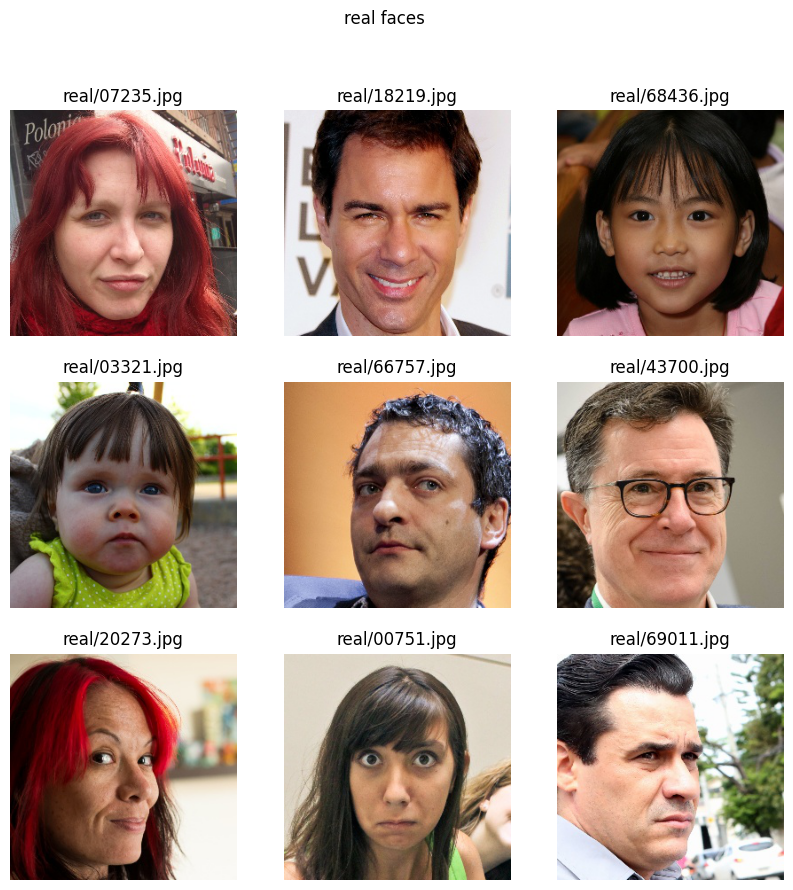

In [ ]:
plot_img('real_vs_fake/real-vs-fake/train/real', "real")

7WJRTXWW3S.jpg
7GAH8MNDIV.jpg
H9BM34RRE3.jpg
YF33BVUPRC.jpg
F22FAGC6G5.jpg
VR1E8XFYIK.jpg
AEVTDMY79T.jpg
EG12XE5CJW.jpg
JM0C29TII0.jpg


<module 'matplotlib.pyplot' from '/usr/local/lib/python3.10/dist-packages/matplotlib/pyplot.py'>

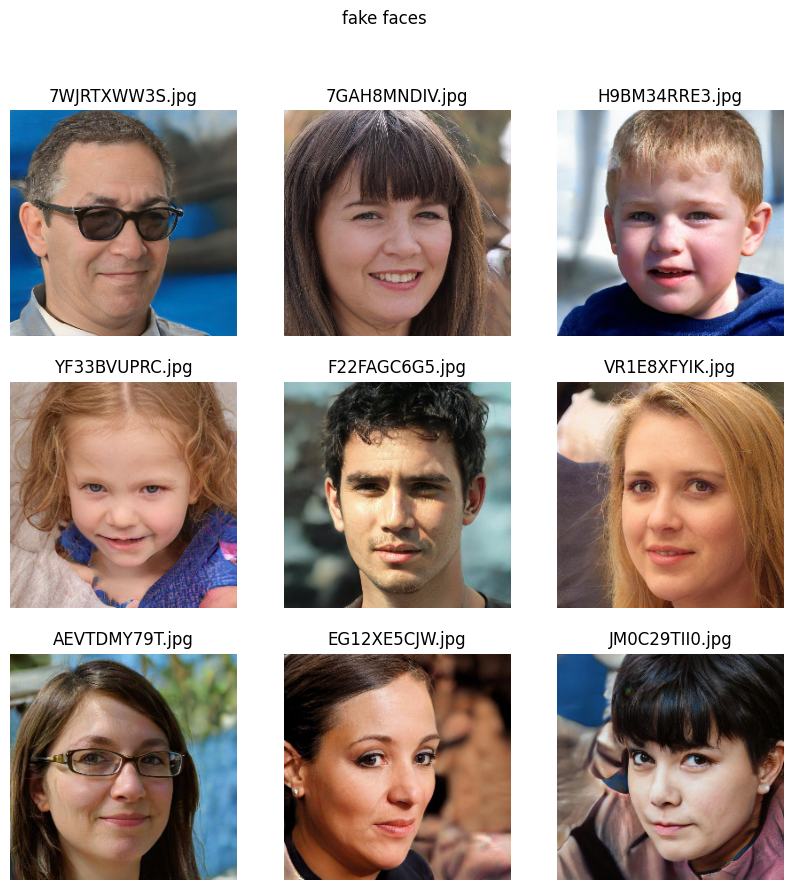

In [ ]:
plot_img('real_vs_fake/real-vs-fake/train/fake', "fake")

In [15]:
df_train[(df_train.id=="F22FAGC6G5")]

original_path          id  label  \
34817  /kaggle/input/1-million-fake-faces/1m_faces_12...  F22FAGC6G5      0   

      label_str                       path  
34817      fake  train/fake/F22FAGC6G5.jpg

### Second Dataset

In [16]:
datasetHard=pd.read_csv("data.csv")
datasetHard.head()

images_id label
0    real_1  real
1   real_10  real
2  real_100  real
3  real_101  real
4  real_102  real

In [17]:
X=datasetHard["images_id"]
y=datasetHard["label"]

In [18]:
X_train_hard, X_test_hard, y_train_hard, y_test_hard = train_test_split(X, y, test_size=0.25, random_state=1)
X_train_hard, X_val_hard, y_train_hard, y_val_hard = train_test_split(X_train_hard, y_train_hard, test_size=0.25, random_state=1)

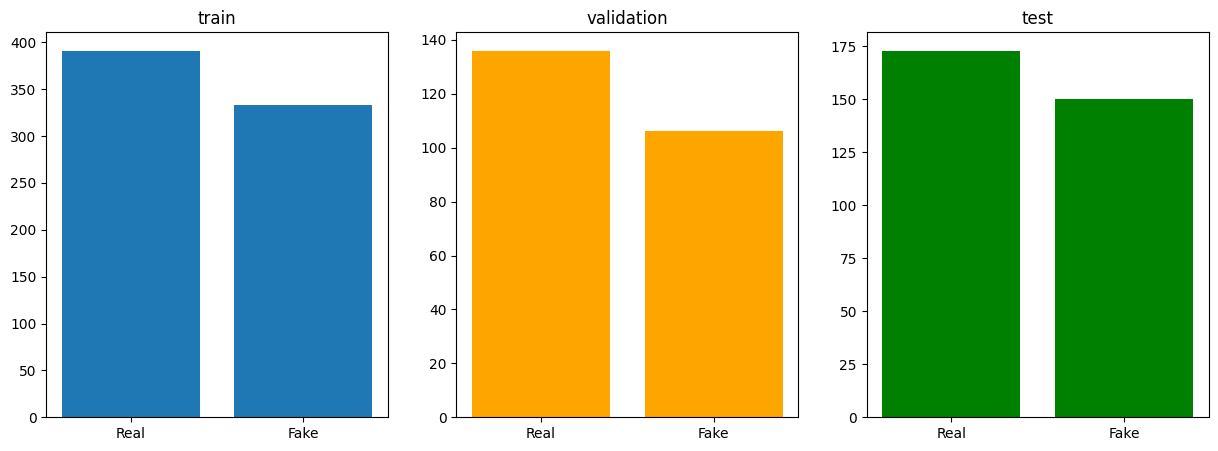

In [19]:
fig, axs = plt.subplots(1,3,figsize=(15,5))
axs[0].bar(y_train_hard.value_counts().index, y_train_hard.value_counts(), tick_label=['Real','Fake'])
axs[1].bar(y_val_hard.value_counts().index, y_val_hard.value_counts(), tick_label=['Real','Fake'], color='orange')
axs[2].bar(y_test_hard.value_counts().index, y_test_hard.value_counts(), tick_label=['Real','Fake'], color='green')
axs[0].title.set_text("train")
axs[1].title.set_text("validation")
axs[2].title.set_text("test")

l/real_437.jpg
l/real_295.jpg
al/real_81.jpg
l/real_169.jpg
l/real_357.jpg
al/real_98.jpg
l/real_378.jpg
l/real_538.jpg
l/real_274.jpg


<module 'matplotlib.pyplot' from '/usr/local/lib/python3.10/dist-packages/matplotlib/pyplot.py'>

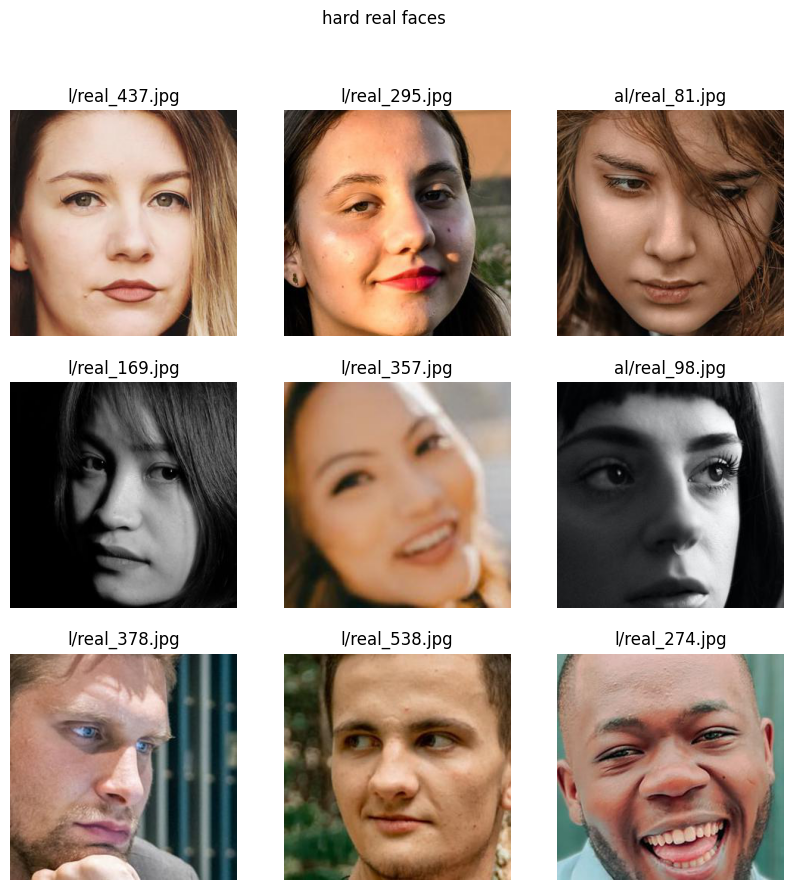

In [ ]:
plot_img('real', "hard real")

e/fake_241.jpg
e/fake_599.jpg
e/fake_609.jpg
e/fake_105.jpg
e/fake_664.jpg
e/fake_451.jpg
e/fake_405.jpg
e/fake_666.jpg
e/fake_337.jpg


<module 'matplotlib.pyplot' from '/usr/local/lib/python3.10/dist-packages/matplotlib/pyplot.py'>

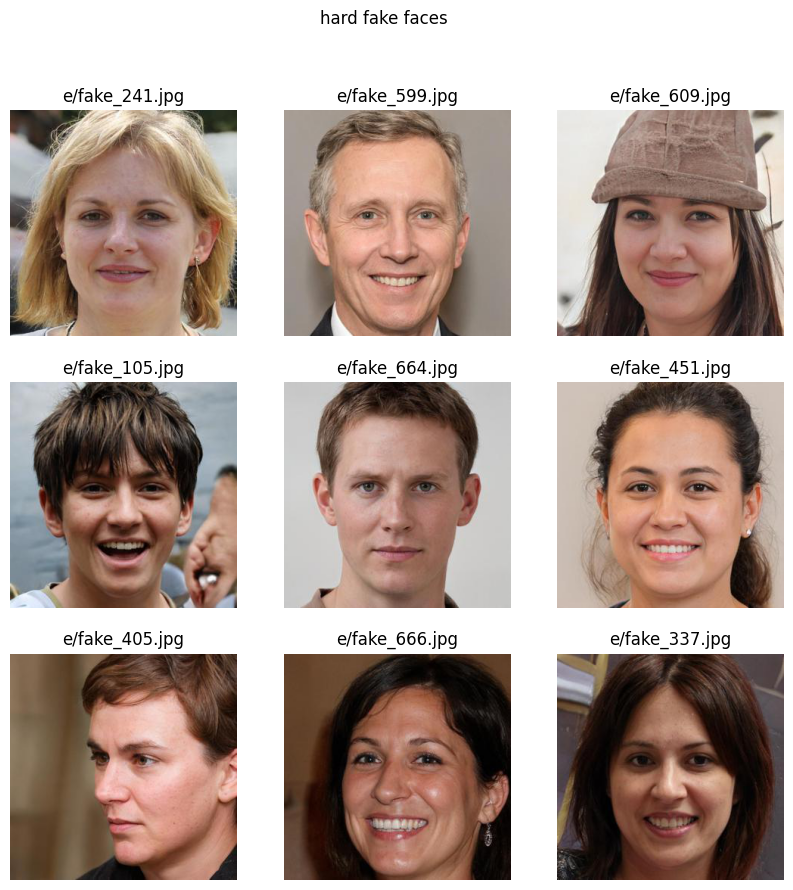

In [ ]:
plot_img('fake', "hard fake")

### Combine Two Dataset

In [20]:
base_path="real_vs_fake/real-vs-fake"
datasets=np.array(os.listdir(base_path))
for dataset in datasets:
  for type in np.array(os.listdir(base_path +"/" +dataset)):
    for filename in np.array(os.listdir(base_path +"/" +dataset + '/' + type)):
      path = base_path +"/" +dataset + '/' + type + "/"
      path_dst = ""
      if dataset == "train":
        path_dst += "train/"
      elif dataset == "valid":
        path_dst += "valid/"
      else:
        path_dst += "test/"

      if type == "fake":
        path_dst += "fake/"
      else:
        path_dst += "real/"

      dst ="real_vs_fake_" + filename
      src =path + filename
      dst =path_dst + dst
      os.rename(src, dst)

In [21]:
for label, row in X_train_hard.items():
  path_src = ""
  path_dst = "train/"
  if "real" in row:
    path_src += "real/"
    path_dst += "real/"
  if "fake" in row:
    path_src += "fake/"
    path_dst += "fake/"

  dst ="hard_real_vs_fake_" + row + ".jpg"
  src =path_src + row + ".jpg"
  dst =path_dst + dst
  os.rename(src, dst)

for label, row in X_test_hard.items():
  path_src = ""
  path_dst = "test/"
  if "real" in row:
    path_src += "real/"
    path_dst += "real/"
  if "fake" in row:
    path_src += "fake/"
    path_dst += "fake/"

  dst ="hard_real_vs_fake_" + row + ".jpg"
  src =path_src + row + ".jpg"
  dst =path_dst + dst
  os.rename(src, dst)

for label, row in X_val_hard.items():
  path_src = ""
  path_dst = "valid/"
  if "real" in row:
    path_src += "real/"
    path_dst += "real/"
  if "fake" in row:
    path_src += "fake/"
    path_dst += "fake/"

  dst ="hard_real_vs_fake_" + row + ".jpg"
  src =path_src + row + ".jpg"
  dst =path_dst + dst
  os.rename(src, dst)

### Create Image dataset

In [12]:
img_size=(224,224)
batch_size = 32

# Load the training data
train_ds = tf.keras.utils.image_dataset_from_directory(
  "train",
  seed=123,
  image_size=img_size,
  batch_size=batch_size)

# Load the validation data
val_ds = tf.keras.utils.image_dataset_from_directory(
  "valid",
  seed=123,
  image_size=img_size,
  batch_size=batch_size)

# Load the test data
test_ds = tf.keras.utils.image_dataset_from_directory(
  "test",
  seed=123,
  image_size=img_size,
  batch_size=batch_size)

# Quick sanity check to make sure it's all loaded properly
print("Training Classes:")
class_names = train_ds.class_names
print(class_names)

print("Validation Classes:")
class_names = val_ds.class_names
print(class_names)

print("Testing Classes:")
class_names = test_ds.class_names
print(class_names)

Found 100724 files belonging to 2 classes.
Found 20242 files belonging to 2 classes.
Found 20323 files belonging to 2 classes.
Training Classes:
['fake', 'real']
Validation Classes:
['fake', 'real']
Testing Classes:
['fake', 'real']


## Original Model CNN from CIFAKE Paper

In [41]:
# Building the CNN
layersCNNPaperOri = []
layersCNNPaperOri.append(tf.keras.layers.Rescaling(1./255)) # Normalise pixel values
layersCNNPaperOri.append(tf.keras.layers.Conv2D(32, 3, activation='relu'))
layersCNNPaperOri.append(tf.keras.layers.MaxPooling2D())
layersCNNPaperOri.append(tf.keras.layers.Conv2D(32, 3, activation='relu'))
layersCNNPaperOri.append(tf.keras.layers.MaxPooling2D())
layersCNNPaperOri.append(tf.keras.layers.Flatten())

# Building the ANN
layersCNNPaperOri.append(tf.keras.layers.Dense(64, activation='relu'))
layersCNNPaperOri.append(tf.keras.layers.Dense(1, activation='sigmoid'))

# Create and compile the model from layers
modelCNNPaperOri = tf.keras.Sequential(layersCNNPaperOri)
modelCNNPaperOri.compile(
  optimizer='adam',
  loss=tf.keras.losses.BinaryCrossentropy(),
  metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])

# Build the model so we can see a summary
modelCNNPaperOri.build(input_shape=(None, 224, 224, 3))
modelCNNPaperOri.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_3 (Rescaling)     (None, 224, 224, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 111, 111, 32)     0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 109, 109, 32)      9248      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 54, 54, 32)       0         
 2D)                                                             
                                                                 
 flatten_2 (Flatten)         (None, 93312)            

In [42]:
historyCNNOri = modelCNNPaperOri.fit(
  train_ds,
  validation_data=val_ds,
  epochs=5,
  verbose=1
)

Epoch 1/5
3148/3148 [==============================] - 198s 62ms/step - loss: 0.4392 - accuracy: 0.7902 - precision_3: 0.7935 - recall_3: 0.7843 - val_loss: 0.3453 - val_accuracy: 0.8475 - val_precision_3: 0.9074 - val_recall_3: 0.7736
Epoch 2/5
3148/3148 [==============================] - 206s 65ms/step - loss: 0.2135 - accuracy: 0.9124 - precision_3: 0.9080 - recall_3: 0.9176 - val_loss: 0.2616 - val_accuracy: 0.8963 - val_precision_3: 0.9248 - val_recall_3: 0.8624
Epoch 3/5
3148/3148 [==============================] - 253s 80ms/step - loss: 0.0984 - accuracy: 0.9623 - precision_3: 0.9603 - recall_3: 0.9644 - val_loss: 0.3118 - val_accuracy: 0.9025 - val_precision_3: 0.9417 - val_recall_3: 0.8579
Epoch 4/5
3148/3148 [==============================] - 197s 62ms/step - loss: 0.0507 - accuracy: 0.9813 - precision_3: 0.9808 - recall_3: 0.9817 - val_loss: 0.4398 - val_accuracy: 0.8898 - val_precision_3: 0.9460 - val_recall_3: 0.8265
Epoch 5/5
3148/3148 [==============================] - 1

### Save model to file

In [49]:
modelCNNPaperOri.save("modelCNNPaperOri.h5")

In [50]:
drive.mount('/content/drive', force_remount=True)
# copy it there
!cp modelCNNPaperOri.h5 /content/drive/MyDrive/Kuliah\ Tel-U/semester\ 6/viskom/tubes

Mounted at /content/drive


### Load model that exist from file

In [47]:
# !cp /content/drive/MyDrive/Kuliah\ Tel-U/semester\ 6/viskom/tubes/modelCNNPaperOri.h5 modelCNNPaperOri.h5

In [10]:
modelCNNPaperOri = load_model('modelCNNPaperOri.h5')

## Create Model CNN Modification

In [43]:
# Building the CNN
layersCNNPaper = []
layersCNNPaper.append(tf.keras.layers.Rescaling(1./255)) # Normalise pixel values
layersCNNPaper.append(tf.keras.layers.Conv2D(32, 3, activation='relu'))
layersCNNPaper.append(tf.keras.layers.MaxPooling2D())
layersCNNPaper.append(tf.keras.layers.Flatten())

# Building the ANN
layersCNNPaper.append(tf.keras.layers.Dense(64, activation='relu'))
layersCNNPaper.append(tf.keras.layers.Dense(1, activation='sigmoid'))

# Create and compile the model from layers
modelCNNPaper = tf.keras.Sequential(layersCNNPaper)
modelCNNPaper.compile(
  optimizer='adam',
  loss=tf.keras.losses.BinaryCrossentropy(),
  metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])

# Build the model so we can see a summary
modelCNNPaper.build(input_shape=(None, 224, 224, 3))
modelCNNPaper.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_4 (Rescaling)     (None, 224, 224, 3)       0         
                                                                 
 conv2d_5 (Conv2D)           (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 111, 111, 32)     0         
 2D)                                                             
                                                                 
 flatten_3 (Flatten)         (None, 394272)            0         
                                                                 
 dense_8 (Dense)             (None, 64)                25233472  
                                                                 
 dense_9 (Dense)             (None, 1)                 65        
                                                      

In [44]:
historyCNN = modelCNNPaper.fit(
  train_ds,
  validation_data=val_ds,
  epochs=5,
  verbose=1
)

Epoch 1/5
3148/3148 [==============================] - 187s 59ms/step - loss: 0.4176 - accuracy: 0.8178 - precision_4: 0.8195 - recall_4: 0.8149 - val_loss: 0.3178 - val_accuracy: 0.8648 - val_precision_4: 0.8406 - val_recall_4: 0.8998
Epoch 2/5
3148/3148 [==============================] - 188s 60ms/step - loss: 0.1846 - accuracy: 0.9262 - precision_4: 0.9243 - recall_4: 0.9284 - val_loss: 0.2697 - val_accuracy: 0.8979 - val_precision_4: 0.8931 - val_recall_4: 0.9037
Epoch 3/5
3148/3148 [==============================] - 189s 60ms/step - loss: 0.0893 - accuracy: 0.9663 - precision_4: 0.9655 - recall_4: 0.9672 - val_loss: 0.3214 - val_accuracy: 0.8962 - val_precision_4: 0.9127 - val_recall_4: 0.8758
Epoch 4/5
3148/3148 [==============================] - 187s 59ms/step - loss: 0.0559 - accuracy: 0.9797 - precision_4: 0.9793 - recall_4: 0.9802 - val_loss: 0.4487 - val_accuracy: 0.8838 - val_precision_4: 0.9357 - val_recall_4: 0.8239
Epoch 5/5
3148/3148 [==============================] - 1

### Save model to file

In [51]:
modelCNNPaper.save("modelCNNPaper.h5")

In [52]:
drive.mount('/content/drive', force_remount=True)
# copy it there
!cp modelCNNPaper.h5 /content/drive/MyDrive/Kuliah\ Tel-U/semester\ 6/viskom/tubes

Mounted at /content/drive


### Load model that exist from file

In [ ]:
# !cp /content/drive/MyDrive/Kuliah\ Tel-U/semester\ 6/viskom/tubes/modelCNNPaper.h5 modelCNNPaper.h5

In [9]:
modelCNNPaper = load_model('modelCNNPaper.h5')

## Create Efficient Net Model


In [84]:
img_shape=(224, 224, 3)
base_model=tf.keras.applications.EfficientNetB4(include_top=False, weights="imagenet",input_shape=img_shape, pooling='max')
base_model.trainable=True
x=base_model.output
x=BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001 )(x)
x = Dense(256, kernel_regularizer = regularizers.l2(l = 0.016),activity_regularizer=regularizers.l1(0.006),
                bias_regularizer=regularizers.l1(0.006) ,activation='relu')(x)
x=Dropout(rate=.4, seed=123)(x)
output=Dense(1, activation='sigmoid')(x)
modelEffNetBin=Model(inputs=base_model.input, outputs=output)
modelEffNetBin.compile(Adamax(learning_rate=.001), loss=tf.keras.losses.BinaryCrossentropy(), metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])
modelEffNetBin.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling_8 (Rescaling)        (None, 224, 224, 3)  0           ['input_4[0][0]']                
                                                                                                  
 normalization_3 (Normalization  (None, 224, 224, 3)  7          ['rescaling_8[0][0]']            
 )                                                                                                
                                                                                            

In [85]:
historyEff=modelEffNetBin.fit(train_ds,
  validation_data=val_ds, epochs=5, verbose=1,
               validation_steps=None,  shuffle=True,  initial_epoch=0) # train the model

Epoch 1/5
3148/3148 [==============================] - 2205s 694ms/step - loss: 0.6348 - accuracy: 0.9726 - precision_7: 0.9724 - recall_7: 0.9728 - val_loss: 0.0824 - val_accuracy: 0.9971 - val_precision_7: 0.9995 - val_recall_7: 0.9948
Epoch 2/5
3148/3148 [==============================] - 2185s 694ms/step - loss: 0.0758 - accuracy: 0.9973 - precision_7: 0.9974 - recall_7: 0.9972 - val_loss: 0.0519 - val_accuracy: 0.9993 - val_precision_7: 0.9997 - val_recall_7: 0.9989
Epoch 3/5
3148/3148 [==============================] - 2135s 678ms/step - loss: 0.0554 - accuracy: 0.9983 - precision_7: 0.9985 - recall_7: 0.9981 - val_loss: 0.0388 - val_accuracy: 0.9992 - val_precision_7: 0.9998 - val_recall_7: 0.9986
Epoch 4/5
3148/3148 [==============================] - 2137s 679ms/step - loss: 0.0459 - accuracy: 0.9988 - precision_7: 0.9989 - recall_7: 0.9987 - val_loss: 0.0333 - val_accuracy: 0.9992 - val_precision_7: 0.9998 - val_recall_7: 0.9985
Epoch 5/5
3148/3148 [===========================

### Save model to file

In [86]:
modelEffNetBin.save("modelEffNetBinB4.h5")

TypeError: ignored

In [7]:
drive.mount('/content/drive', force_remount=True)
# copy it there
!cp modelEffNetBinB4.h5 /content/drive/MyDrive/Kuliah\ Tel-U/semester\ 6/viskom/tubes

Mounted at /content/drive


### Load model that exist from file

In [ ]:
# !cp /content/drive/MyDrive/Kuliah\ Tel-U/semester\ 6/viskom/tubes/modelEffNetBin.h5 modelEffNetBin.h5

In [8]:
modelEffNetBin = load_model('modelEffNetBin.h5')

## Evaluation

### Model CNN Paper Original

Text(0.5, 1.0, 'Training and validation loss historyCNNOri')

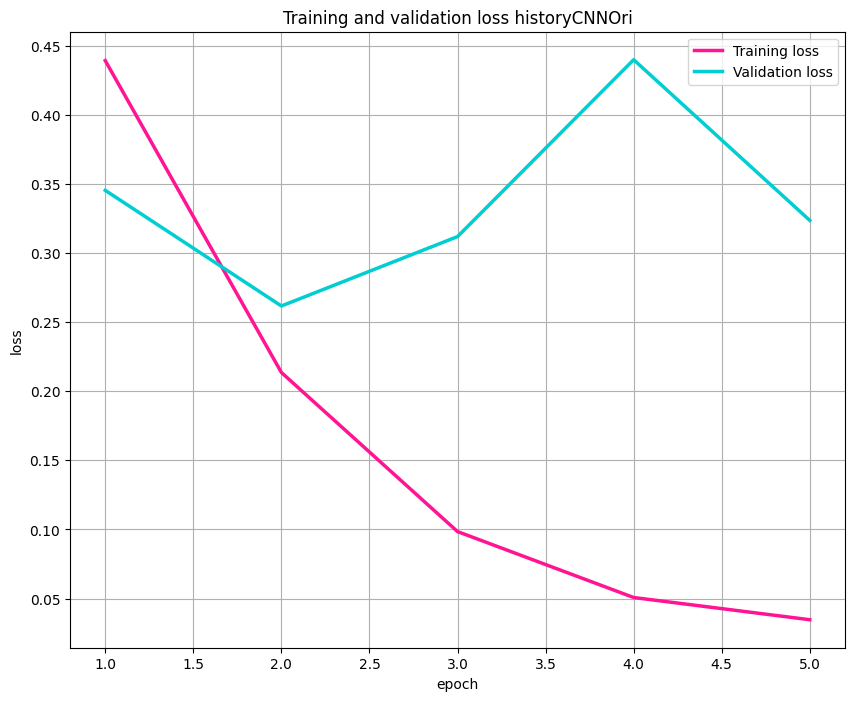

In [45]:
epochs = 5
stats_df=pd.DataFrame(historyCNNOri.history)
stats_df['epoch']=list(range(1, epochs+1))
plt.figure(figsize=(10, 8))
sn.lineplot(y='loss', x='epoch', data=stats_df, color='deeppink', linewidth=2.5, label="Training loss")
sn.lineplot(y='val_loss', x='epoch', data=stats_df, color='darkturquoise', linewidth=2.5, label="Validation loss")
plt.grid()
plt.legend()
plt.title("Training and validation loss historyCNNOri")

Text(0.5, 1.0, 'Training and validation accuracy historyCNNOri')

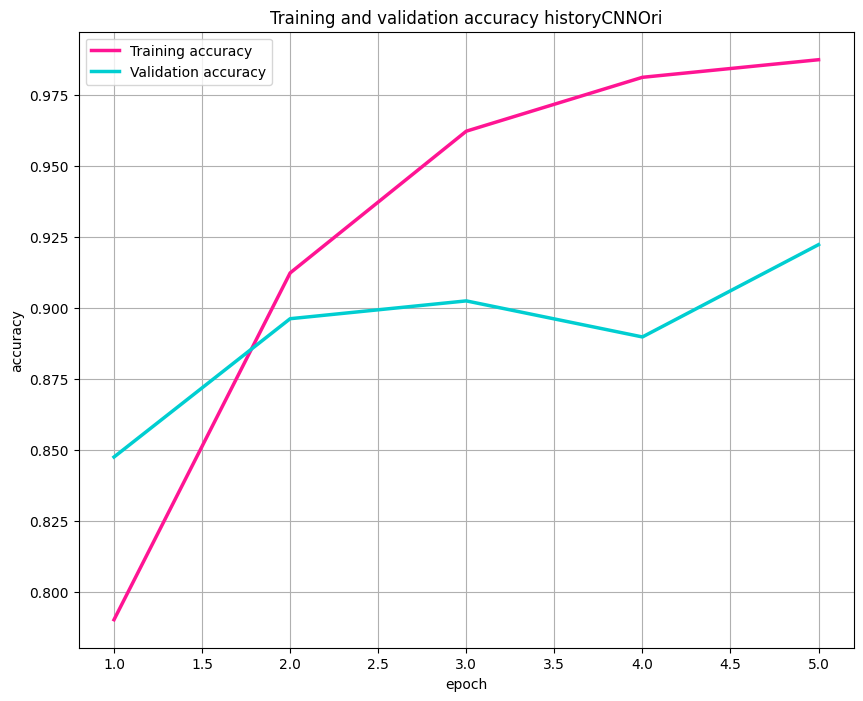

In [46]:
epoch = 5
stats_df=pd.DataFrame(historyCNNOri.history)
stats_df['epoch']=list(range(1, epochs+1))
plt.figure(figsize=(10, 8))
sn.lineplot(y='accuracy', x='epoch', data=stats_df, color='deeppink', linewidth=2.5, label="Training accuracy")
sn.lineplot(y='val_accuracy', x='epoch', data=stats_df, color='darkturquoise', linewidth=2.5, \
            label="Validation accuracy")
plt.grid()
plt.legend()
plt.title("Training and validation accuracy historyCNNOri")

### Model CNN Modification

Text(0.5, 1.0, 'Training and validation loss historyCNN')

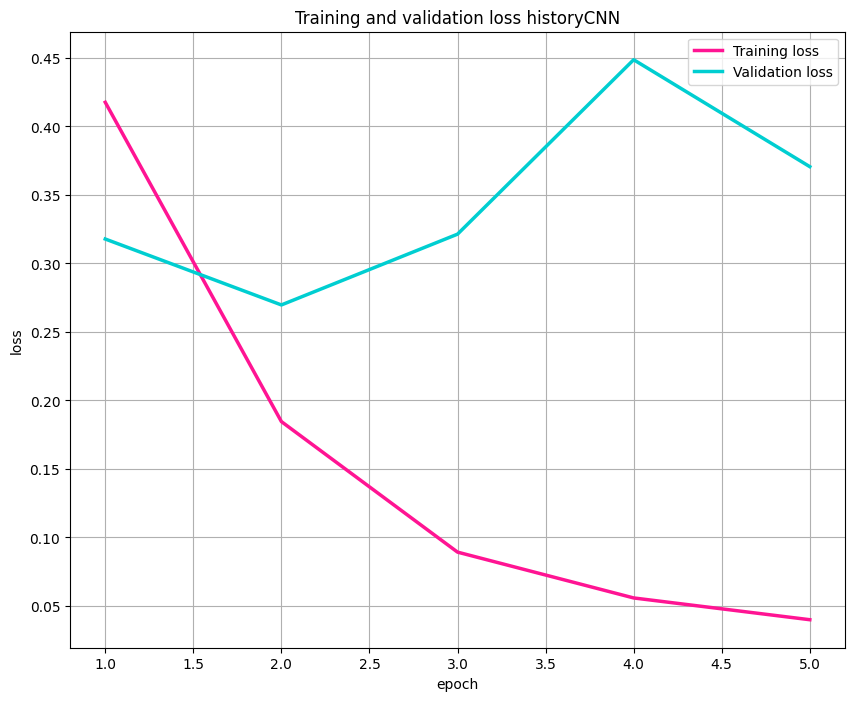

In [47]:
epochs = 5
stats_df=pd.DataFrame(historyCNN.history)
stats_df['epoch']=list(range(1, epochs+1))
plt.figure(figsize=(10, 8))
sn.lineplot(y='loss', x='epoch', data=stats_df, color='deeppink', linewidth=2.5, label="Training loss")
sn.lineplot(y='val_loss', x='epoch', data=stats_df, color='darkturquoise', linewidth=2.5, label="Validation loss")
plt.grid()
plt.legend()
plt.title("Training and validation loss historyCNN")

Text(0.5, 1.0, 'Training and validation accuracy historyCNN')

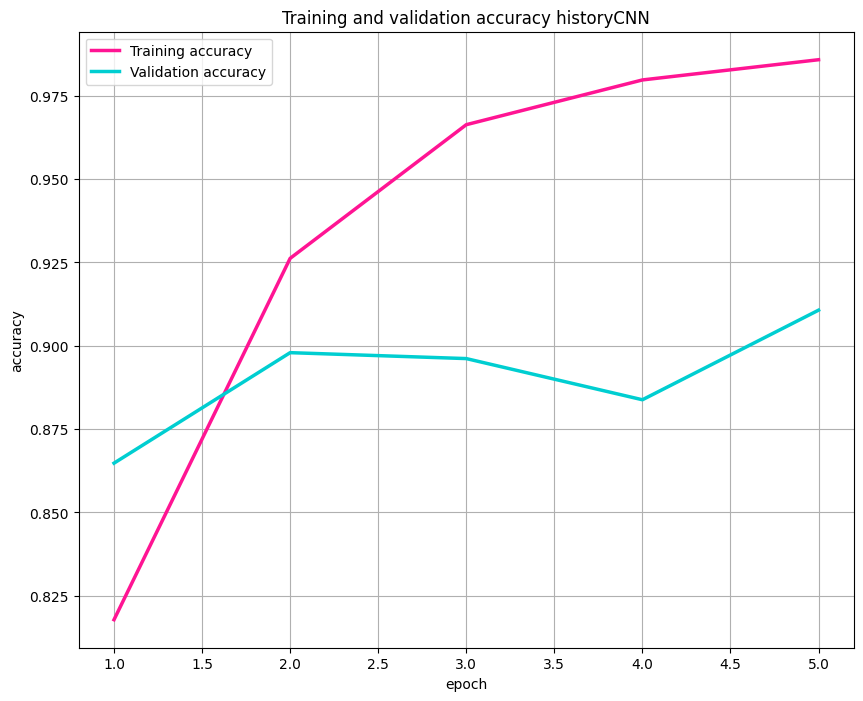

In [48]:
epoch = 5
stats_df=pd.DataFrame(historyCNN.history)
stats_df['epoch']=list(range(1, epochs+1))
plt.figure(figsize=(10, 8))
sn.lineplot(y='accuracy', x='epoch', data=stats_df, color='deeppink', linewidth=2.5, label="Training accuracy")
sn.lineplot(y='val_accuracy', x='epoch', data=stats_df, color='darkturquoise', linewidth=2.5, \
            label="Validation accuracy")
plt.grid()
plt.legend()
plt.title("Training and validation accuracy historyCNN")

### Model EfficientNet

Text(0.5, 1.0, 'Training and validation loss historyEff')

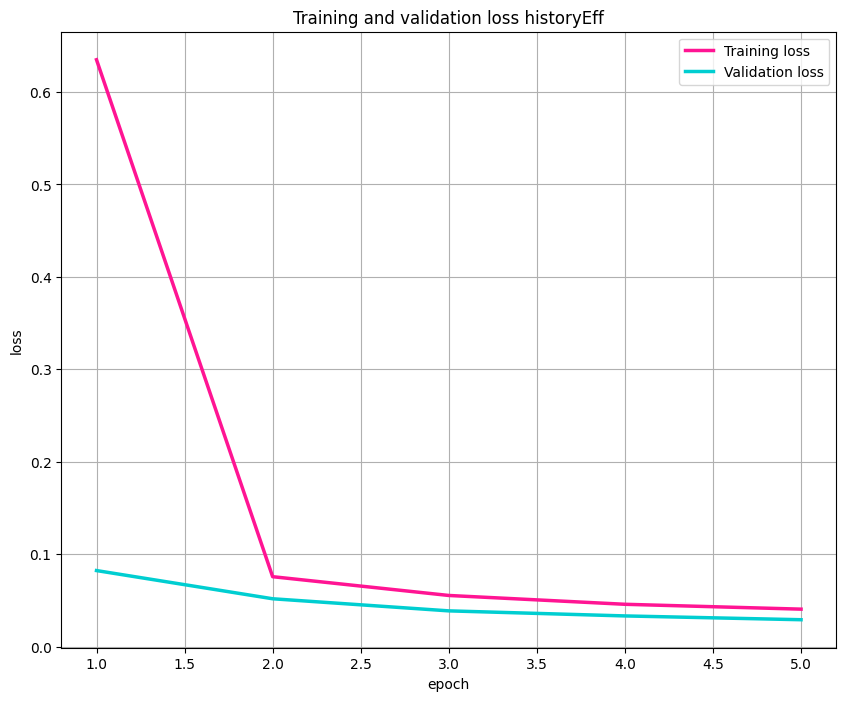

In [87]:
epochs = 5
stats_df=pd.DataFrame(historyEff.history)
stats_df['epoch']=list(range(1, epochs+1))
plt.figure(figsize=(10, 8))
sn.lineplot(y='loss', x='epoch', data=stats_df, color='deeppink', linewidth=2.5, label="Training loss")
sn.lineplot(y='val_loss', x='epoch', data=stats_df, color='darkturquoise', linewidth=2.5, label="Validation loss")
plt.grid()
plt.legend()
plt.title("Training and validation loss historyEff")

Text(0.5, 1.0, 'Training and validation accuracy historyEff')

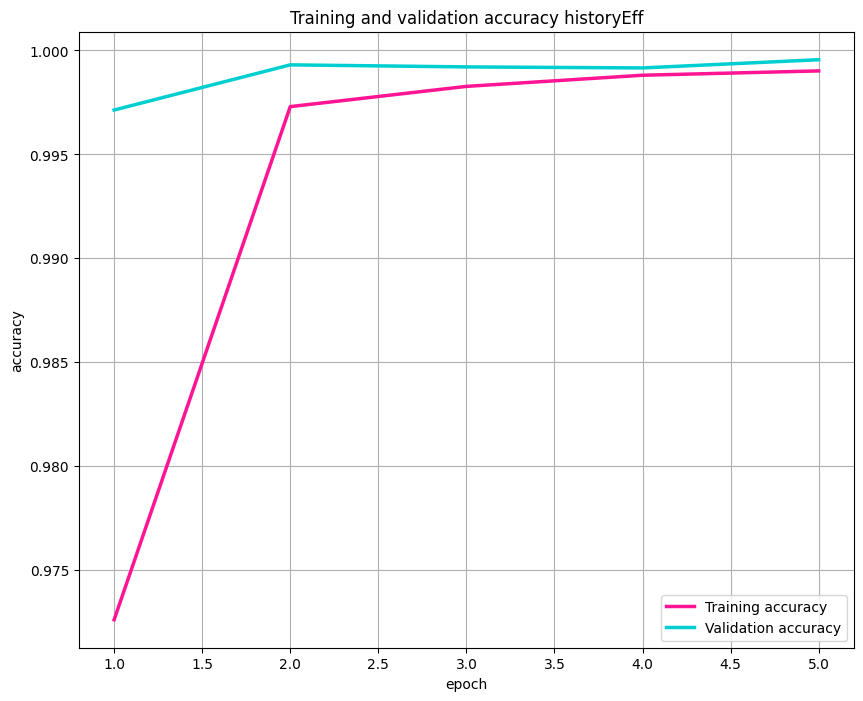

In [88]:
epoch = 5
stats_df=pd.DataFrame(historyEff.history)
stats_df['epoch']=list(range(1, epochs+1))
plt.figure(figsize=(10, 8))
sn.lineplot(y='accuracy', x='epoch', data=stats_df, color='deeppink', linewidth=2.5, label="Training accuracy")
sn.lineplot(y='val_accuracy', x='epoch', data=stats_df, color='darkturquoise', linewidth=2.5, \
            label="Validation accuracy")
plt.grid()
plt.legend()
plt.title("Training and validation accuracy historyEff")

## Testing Using Data Test

In [99]:
modelCNNPaperOri.evaluate(test_ds)

636/636 [==============================] - 53s 82ms/step - loss: 0.3253 - accuracy: 0.9183 - precision_3: 0.9154 - recall_3: 0.9217


[0.32534411549568176,
 0.9183191657066345,
 0.9153620600700378,
 0.9216748476028442]

In [100]:
modelCNNPaper.evaluate(test_ds)

636/636 [==============================] - 44s 68ms/step - loss: 0.3832 - accuracy: 0.9103 - precision_4: 0.8933 - recall_4: 0.9316


[0.38319164514541626,
 0.9102987051010132,
 0.8933396339416504,
 0.9316256046295166]

In [94]:
modelEffNetBin.evaluate(test_ds)

636/636 [==============================] - 98s 152ms/step - loss: 0.0302 - accuracy: 0.9990 - precision_7: 0.9989 - recall_7: 0.9991


[0.030238989740610123,
 0.9990158677101135,
 0.9989164471626282,
 0.9991133213043213]

In [13]:
# extract Test dataset true
true_labels=[]
pred_modelCNNPaperOri = []
pred_modelCNNPaper = []
pred_modelEffNetBin = []
for batch in iter(test_ds):
  pred1 = modelCNNPaperOri.predict(batch[0])
  pred2 = modelCNNPaper.predict(batch[0])
  pred3 = modelEffNetBin.predict(batch[0])

  pred_modelCNNPaperOri.append(pred1.round())
  pred_modelCNNPaper.append(pred2.round())
  pred_modelEffNetBin.append(pred3.round())
  true_labels.append(batch[1])

true_labels_np_cnn = np.concatenate(true_labels)
pred_labels_modelCNNPaperOri = np.concatenate(pred_modelCNNPaperOri)
pred_labels_modelCNNPaper = np.concatenate(pred_modelCNNPaper)
pred_labels_modelEffNetBin = np.concatenate(pred_modelEffNetBin)

1/1 [==============================] - 3s 3s/step


### Confusion Matrix

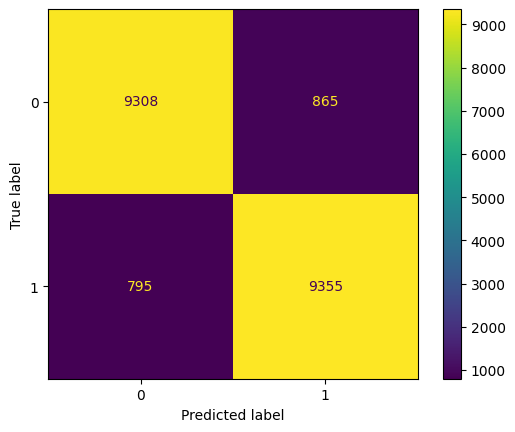

In [14]:
ConfusionMatrixDisplay.from_predictions(true_labels_np_cnn, pred_labels_modelCNNPaperOri)
plt.show()

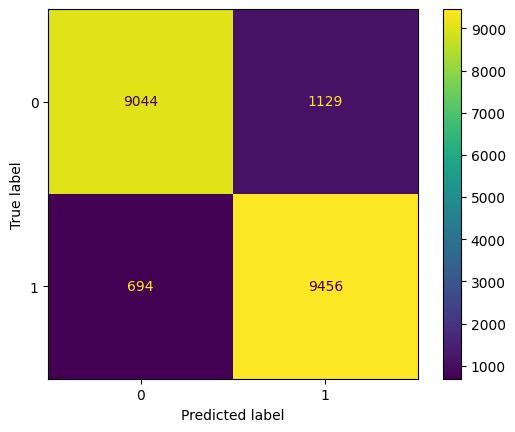

In [16]:
ConfusionMatrixDisplay.from_predictions(true_labels_np_cnn, pred_labels_modelCNNPaper)
plt.show()

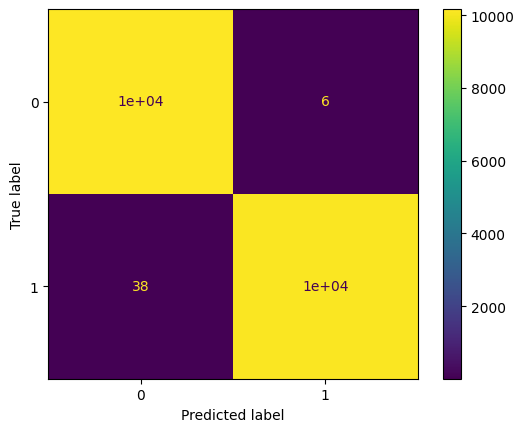

In [17]:
ConfusionMatrixDisplay.from_predictions(true_labels_np_cnn, pred_labels_modelEffNetBin)
plt.show()

In [19]:
print(classification_report(true_labels_np_cnn, pred_labels_modelCNNPaperOri))

              precision    recall  f1-score   support

           0       0.92      0.91      0.92     10173
           1       0.92      0.92      0.92     10150

    accuracy                           0.92     20323
   macro avg       0.92      0.92      0.92     20323
weighted avg       0.92      0.92      0.92     20323



In [15]:
print(classification_report(true_labels_np_cnn, pred_labels_modelCNNPaper))

              precision    recall  f1-score   support

           0       0.93      0.89      0.91     10173
           1       0.89      0.93      0.91     10150

    accuracy                           0.91     20323
   macro avg       0.91      0.91      0.91     20323
weighted avg       0.91      0.91      0.91     20323



In [18]:
print(classification_report(true_labels_np_cnn, pred_labels_modelEffNetBin))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     10173
           1       1.00      1.00      1.00     10150

    accuracy                           1.00     20323
   macro avg       1.00      1.00      1.00     20323
weighted avg       1.00      1.00      1.00     20323



## Testing Using Image from internet

In [91]:
import numpy as np
from google.colab import files
import tensorflow as tf
n = 4
images = []
for i in range(n):
  uploaded = files.upload()
  for fn in uploaded.keys():
    images.append(fn)

path_images = []
pred_images_modelCNNPaperOri = []
pred_images_modelCNNPaper = []
pred_images_modelEffNetBin = []
for fn in images:

  # predicting images
  path = '/content/' + fn
  path_images.append(path)

  image_ds = []
  imge = cv2.imread(path)
  resize = cv2.resize(imge,(224,224))
  image_ds.append(resize)
  image = np.array(image_ds)

  pred1 = modelCNNPaperOri.predict(image)
  pred_images_modelCNNPaperOri.append(pred1.round())
  pred2 = modelCNNPaper.predict(image)
  pred_images_modelCNNPaper.append(pred2.round())
  pred3 = modelEffNetBin.predict(image)
  pred_images_modelEffNetBin.append(pred3.round())


Saving face-girl.jpg to face-girl.jpg


Saving faake.webp to faake (3).webp


Saving real.jpg to real (8).jpg


Saving Pope-francis-artificial-intelligence-generated-image-white-coat.webp to Pope-francis-artificial-intelligence-generated-image-white-coat (6).webp
1/1 [==============================] - 0s 28ms/step


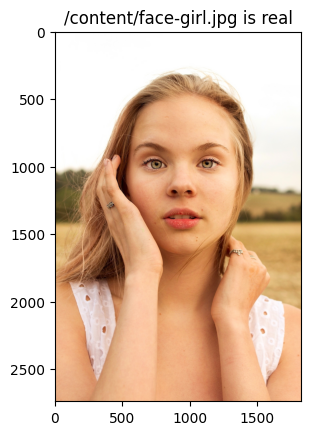

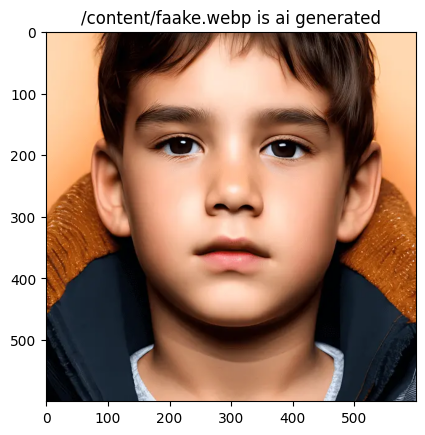

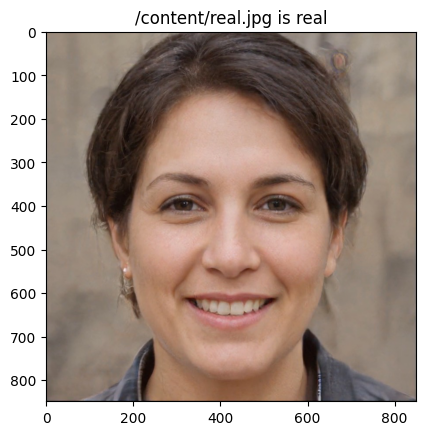

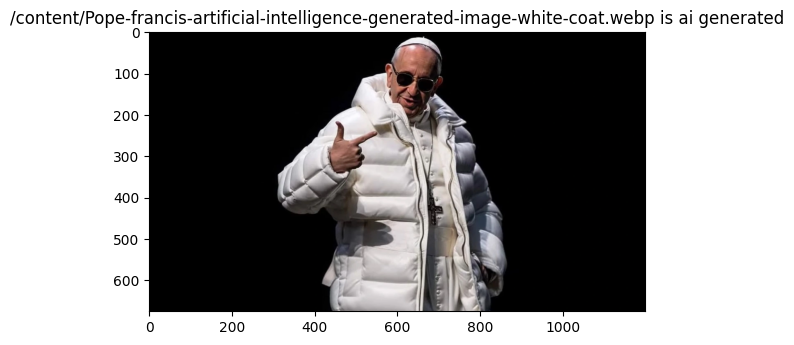

In [92]:
for i in range(n):
  title = ""
  if pred_images_modelCNNPaperOri[i] == 1:
    title = path_images[i] + " is ai generated"
  else:
    title = path_images[i] + " is real"

  f1 = plt.figure()
  imageAi = plt.imread(path_images[i])
  plt.imshow(imageAi)
  plt.title(title)


plt.show()

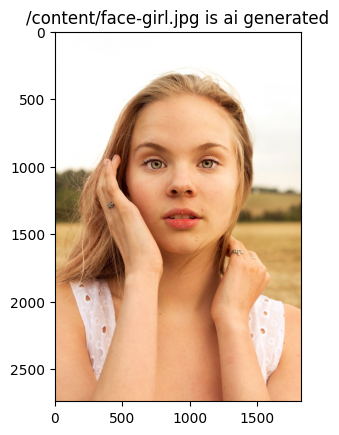

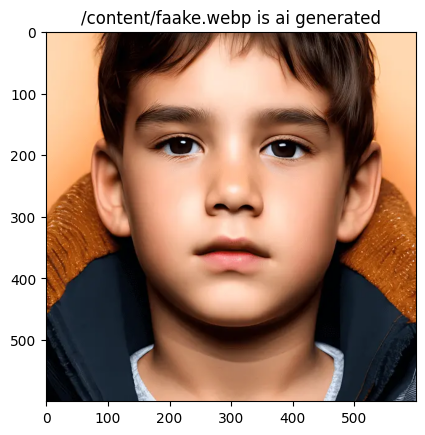

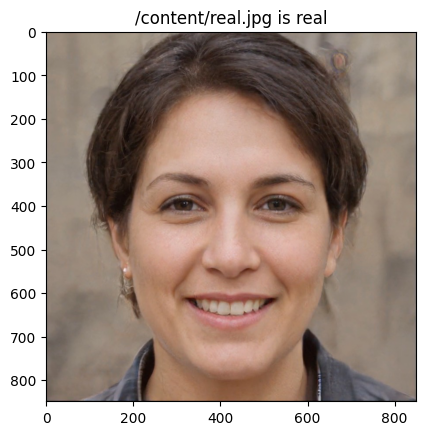

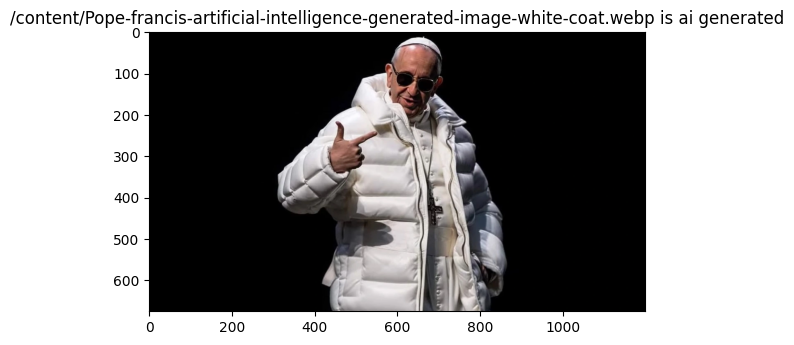

In [93]:
for i in range(n):
  title = ""
  if pred_images_modelCNNPaper[i] == 1:
    title = path_images[i] + " is ai generated"
  else:
    title = path_images[i] + " is real"

  f1 = plt.figure()
  imageAi = plt.imread(path_images[i])
  plt.imshow(imageAi)
  plt.title(title)


plt.show()

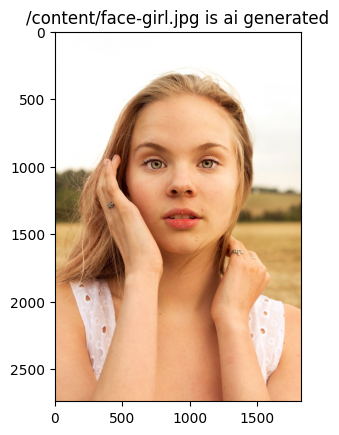

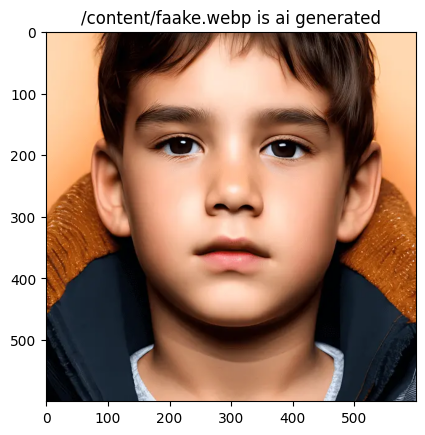

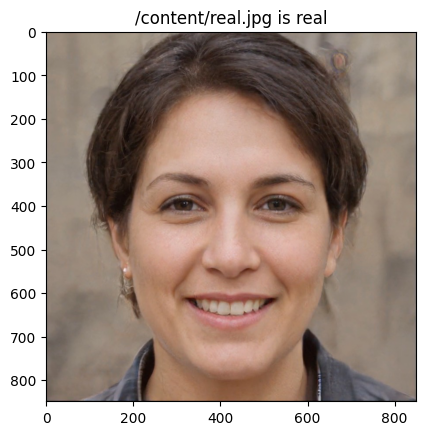

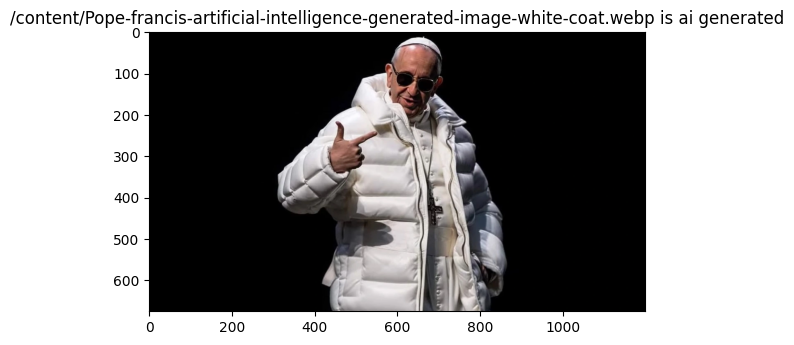

In [94]:
for i in range(n):
  title = ""
  if pred_images_modelEffNetBin[i] == 1:
    title = path_images[i] + " is ai generated"
  else:
    title = path_images[i] + " is real"

  f1 = plt.figure()
  imageAi = plt.imread(path_images[i])
  plt.imshow(imageAi)
  plt.title(title)


plt.show()